## Fast Agent
Build a SQL Agent fast

In [1]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")

In [2]:
from typing import TypedDict

class RuntimeContext(TypedDict):
    db: SQLDatabase

In [3]:
from langchain_core.tools import tool
from langgraph.runtime import Runtime, get_runtime

@tool
def execute_sql(query: str) -> str:
    """Execute a SQLite command and return results."""
    runtime = get_runtime(RuntimeContext)
    db = runtime.context["db"]

    try:
        return db.run(query)
    except Exception as e:
        return f"Error: {e}"


In [4]:
SYSTEM = f"""You are a careful SQLite analyst.

Rules:
- Think step-by-step.
- When you need data, call the tool `execute_sql` with ONE SELECT query.
- Read-only only; no INSERT/UPDATE/DELETE/ALTER/DROP/CREATE/REPLACE/TRUNCATE.
- Limit to 5 rows of output unless the user explicitly asks otherwise.
- If the tool returns 'Error:', revise the SQL and try again.
- Prefer explicit column lists; avoid SELECT *.
"""

In [5]:
from langchain.agents import create_agent
from langchain_core.messages import SystemMessage

agent = create_agent(
    model="openai:gpt-5",
    tools=[execute_sql],
    prompt=SYSTEM,
    context_schema=RuntimeContext,
)

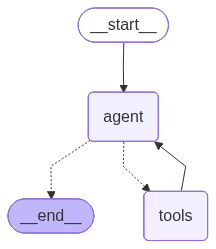

In [10]:
from IPython.display import Image, display
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [6]:
question = "Which table has the largest number of entries?"

for step in agent.stream(
    {"messages": question},
    context = {"db": db},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which table has the largest number of entries?
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_HAfOvbvrHOFMCj1DvDMLMscX)
 Call ID: call_HAfOvbvrHOFMCj1DvDMLMscX
  Args:
    query: SELECT name, SUM(ncell) AS approx_rows
FROM dbstat
WHERE name NOT LIKE 'sqlite_%' AND pagetype = 'leaf'
GROUP BY name
ORDER BY approx_rows DESC
LIMIT 1;
================================= Tool Message =================================
Name: execute_sql

[('PlaylistTrack', 8715)]
================================== Ai Message ==================================

PlaylistTrack — about 8,715 rows.


In [7]:
question = "Which genre on average has the longest tracks?"

for step in agent.stream(
    {"messages": question},
    context = {"db": db},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which genre on average has the longest tracks?
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_FmY0t31KV0uWTs4QdPseMBwM)
 Call ID: call_FmY0t31KV0uWTs4QdPseMBwM
  Args:
    query: SELECT g.Name AS genre, ROUND(AVG(t.Milliseconds)) AS avg_milliseconds, ROUND(AVG(t.Milliseconds) / 60000.0, 2) AS avg_minutes
FROM Track AS t
JOIN Genre AS g ON t.GenreId = g.GenreId
GROUP BY g.GenreId, g.Name
ORDER BY AVG(t.Milliseconds) DESC
LIMIT 1;
================================= Tool Message =================================
Name: execute_sql

[('Sci Fi & Fantasy', 2911783.0, 48.53)]
================================== Ai Message ==================================

Sci Fi & Fantasy — average track length about 48.53 minutes.


In [8]:
question = "What are all the tables?"

for step in agent.stream(
    {"messages": question},
    context = {"db": db},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What are all the tables?
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_GOAJ6FpoDpNe1C0FaTOfHA0J)
 Call ID: call_GOAJ6FpoDpNe1C0FaTOfHA0J
  Args:
    query: SELECT name AS table_name
FROM sqlite_master
WHERE type = 'table' AND name NOT LIKE 'sqlite_%'
ORDER BY name;
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), ('Track',)]
================================== Ai Message ==================================

Here are the tables (non-system):

- Album
- Artist
- Customer
- Employee
- Genre
- Invoice
- InvoiceLine
- MediaType
- Playlist
- PlaylistTrack
- Track


Let's try this in Studio